In [20]:
import os
import sys

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

# import user modules
from visualisation.ipython import *
from visualisation.graphs import *
from features.generate_features import *
from models.predict_model import *
from models.train_model import *

# import sklearn classifiers and functions
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

from IPython.display import HTML

%matplotlib inline
HTML(input_toggle())

# Spotify and Machine Learning

The music recommendation problem - why is this a challenge:
1. Scale of catalog - over 30 million songs available, how to determine which ones a user will like and listen to next?
2. Repeated consumption - unlike movies, television or books, users will listen to the same or similar tracks over and over, which can generate a lot of noise in the data
3. Music taste tends to be quite idiosyncratic and each user can have _vastly_ different preferences. As an example, some kinds of music that I like:
    * Instrumental guitar solos (e.g. Stevie Ray Vaughn)
    * Classic rock (e.g. AC/DC, Led Zeppelin)
    * 90's rap and hip hop (e.g. Tupac, Nas)
    * Contemporary electronic and EDM (e.g. deadmau5, Daft Punk)
    * Progressive rock (e.g. Porcupine Tree, Dream Theater)
    * More obscure progressive rock (e.g. Ayreon)
    * Classical piano (e.g. Chopin)
    * Jazz (e.g. Miles Davis)
    * Latin american pop rock (e.g. Mana, Juanes)
4. Implicit versus explicit rating - e.g. with Netflix, users explicitly rate movies, but feedback for music is implicit through streaming behaviour (how many times you listen to a song, do you listen to the whole song, etc.)



The diagram below illustrates the stack that Spotify uses to generate the now famous "Discover Weekly" playlist for each of its individual users:
    
![spotify-ecosystem](images/spotify-ecosystem.png)

# How do they do it?

Spotify uses three primary types of modelling techniques to create the "Discover Weekly" playlist and other music recommendation applications/algorithms:

## Collaborative filtering
1. Analysis and comparison of a user's behaviour and preferences versus other users and their preferences
2. Focus is on using user data to make predictions (e.g. number of times a particular song is played, songs saved on playlists, etc.)
3. Aggregate and remove temporal aspects of user data and then create (very large, sometimes sparse) matrices that represent user behaviour across genres, demographics, etc.
4. Theoretical size of MxN, where M is number of users (140 million users) and N is number of songs available (30 million songs)
5. Basically a lot of matrix multiplication, but optimization techniques are needed due to the large volume of data and high number of features (matrix factorization, probabilistic latent semantic analysis)
6. Spotify uses Luigi (Python) to build complex pipeline of jobs in order to enable collaborative filtering model workflow

## Natural Language Processing
1. Analysis of track metadata, music blogs, forums, social media, etc. to determine what adjectvies and descriptions are available for specific songs or artists
2. Categorise into buckets and then assign weights to each song/artist to determine probability that a particular description will be used to describe that item
3. These weighted categorical representations are then converted to a vector representation of a song/artist, which can then be used for comparison to determine similarity between songs or artists

## Raw audio analysis
1. Used primarily to include new songs that might not have enough social media/mainstream data or user playtime data
2. Analysis of raw features of the audio track (e.g. key, tempo, valence, duration, time signatures, verse/chorus frequency and breakdown, mode, etc.)
3. Spotify uses convolutional neural networks (CNNs) to analyse time-frequency representations of audio frames (basically excerpts of songs) and compute statistics of individual songs based on more musically objective factors

# Can we do better than Spotify?

The correct answer here is "probably not," but that doesn't mean we shouldn't try.

How about using classification models to determine whether a song is "good" or "bad" based on an individual's preferences? We will need a way to access Spotify data first - this can be done via the Spotify web API.

## Classification with Spotify data
Fortunately, there are a variety of libraries available across multiple programming languages that provider wrappers around this API. The library we will be using here is called _spotipy_ (click [here](https://github.com/plamere/spotipy) for more details), which will allow us to extract song data available through the Spotify web API.

For the purposes of showing how the _spotipy_ library works and how machine learning can be used to classify songs, we will be performing binomial classification on two playlists - one playlist will contain only "country" songs and the other will contain "hip hop" songs.

## Step 1 - Create Spotify client object
First, we need to create a Spotify client object in Python using app credentials created via the Spotify Developer website (you can create your own apps, which can be access via a "client ID" and "client secret").

In [2]:
filepath = os.path.join(os.getcwd(), os.pardir, '.env')  # specifies path of .env file
sp = access_spotify(filepath)  # returns a Spotify client object

## Step 2 - Get tracks and song data from playlists

Once we have the Spotify client object, we can access playlist data for user playlists created through the Spotify application using a username and set of playlist IDs. These can be obtained via the application or a web browser running the Spotify Web application. A typical playlist URL link, which includes the playlist ID, will look like this:

https://open.spotify.com/user/federicociner/playlist/7ieLWhjh16EPCRV721NyPl

The URLs for the hip-hop and country playlists we will use for this exercise are as follows:
* Hip-hop: https://open.spotify.com/user/federicociner/playlist/74RF9FPZV75ILPK3Vk7hxg
* Country: https://open.spotify.com/user/federicociner/playlist/5NQnP4gJMAAhmgnvYdRyqz

In order to get song-specific details, we need to extract the song IDs from the items in the playlist array. We will do this by iterating through the "tracks" in each playlist and extracting the track features into a separate list.

In [3]:
# set user name and playlist ID variables
username = 'federicociner'
country_playlist_id = '5NQnP4gJMAAhmgnvYdRyqz'
hiphop_playlist_id = '74RF9FPZV75ILPK3Vk7hxg'

# load playlist object
country_playlist = sp.user_playlist(username, country_playlist_id)
hiphop_playlist = sp.user_playlist(username, hiphop_playlist_id)

# get track objects from country playlist object
country_tracks = country_playlist['tracks']
country_songs = country_tracks['items']
while country_tracks['next']:
    country_tracks = sp.next(country_tracks)
    [country_songs.append(item) for item in country_tracks['items']]

# get track objects from hip-hop playlist object
hiphop_tracks = hiphop_playlist['tracks']
hiphop_songs = hiphop_tracks['items']
while hiphop_tracks['next']:
    hiphop_tracks = sp.next(hiphop_tracks)
    [hiphop_songs.append(item) for item in hiphop_tracks['items']]

# get unique identifiers for each song in both playlists
country_ids = [country_songs[i]['track']['id'] for i in range(0, len(country_songs))]
hiphop_ids = [hiphop_songs[i]['track']['id'] for i in range(0, len(hiphop_songs))]

print 'Country song IDs:\n'
print '\n'.join([str(country_ids[i]) for i in range(0,5)])
print '\n'
print 'Hip-hop song IDs:\n'
print '\n'.join([str(hiphop_ids[i]) for i in range(0,5)])

Country song IDs:

3Ze8nX7ZYOnAgf8A1hDQQ9
7iDa6hUg2VgEL1o1HjmfBn
2OFvjqQ5xHaWqH3EQ4K3S9
6caDnpIOivsjLRXqlJJxCD
2N2EoS0dVmkNT0tfI0OYUA


Hip-hop song IDs:

7wGoVu4Dady5GV0Sv4UIsx
5eqK0tbzUPo2SoeZsov04s
43ZyHQITOjhciSUUNPVRHc
2Xqd0wUttjueBfdcltADOv
6GNifiuBPrKFpwNBYnooFm


## Step 3 - Get song features

Using these song IDs, we can extract features for each song via the *audio_features* method in the Spotify client object. This method allows us to access the "audio features" object of a specific song, and contains all sorts of useful information:
* Technical and structural features such as tempo, key, mode, duration, time signature, etc
* Derived/descriptive features such as "instrumentalness," "speechiness," "loudness", and valence (measure of how happy or sad a song is)

Further, since we will be using this feature set for binomial classification, we will need to label each observation so that our classifiers are able to distinguish a country song from a  hip-hop song during the training phase. To keep things simple, we assign a class of 1 to all country songs and a class of 0 to hip-hop songs (the integer values here are irrelevant as long as they are not the same number).

In [4]:
features = []

# get features for country songs and assign a class of '1'
for i in range(0, len(country_ids), 50):
    audio_features = sp.audio_features(country_ids[i:i + 50])
    for track in audio_features:
        if track is not None:
            features.append(track)
            features[len(features) - 1]['class'] = 1

# get features for hip-hop songs and assign a class of '0'
for i in range(0, len(hiphop_ids), 100):
    audio_features = sp.audio_features(hiphop_ids[i:i + 100])
    for track in audio_features:
        if track is not None:
            features.append(track)
            features[-1]['class'] = 0

Now that we have all the features for each song in one list, we can take a look at what the data looks like. From the example below, we can see that the feature set for any given song is stored as a dictionary data structure within the list. 

In [5]:
features[-1]

{u'acousticness': 0.177,
 u'analysis_url': u'https://api.spotify.com/v1/audio-analysis/6s4kWgzQwsueo3mfllY1s6',
 'class': 0,
 u'danceability': 0.682,
 u'duration_ms': 297427,
 u'energy': 0.92,
 u'id': u'6s4kWgzQwsueo3mfllY1s6',
 u'instrumentalness': 0.00158,
 u'key': 10,
 u'liveness': 0.0443,
 u'loudness': -1.544,
 u'mode': 1,
 u'speechiness': 0.278,
 u'tempo': 82.228,
 u'time_signature': 4,
 u'track_href': u'https://api.spotify.com/v1/tracks/6s4kWgzQwsueo3mfllY1s6',
 u'type': u'audio_features',
 u'uri': u'spotify:track:6s4kWgzQwsueo3mfllY1s6',
 u'valence': 0.835}

Unfortunately, this is not the easiest type of data to use for our purposes, and therefore we are going to convert it to a data frame format using Pandas (and later on, to Numpy multi-dimensional arrays for model training and predictions). We are also going to remove irrelevant features, such as the song ID, analysis URL, and other non-descriptive values.

In [6]:
# convert to data frame remove irrelevant features
df = pd.DataFrame(features)
non_features = ['analysis_url', 'id', 'track_href', 'type', 'uri']
df.drop(labels=non_features, axis=1, inplace=True)

# move class column to the left of the dataframe
col_class = df['class']
df.drop(labels=['class'], axis=1, inplace=True)
df.insert(0, 'class', col_class)

df.head()

,class,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,1,0.1820,0.562,194000,0.474,0.000098,8,0.1140,-8.762,0,0.0351,84.999,4,0.345
1,1,0.0470,0.643,163870,0.783,0.000000,10,0.0830,-6.458,1,0.0856,154.084,4,0.579
2,1,0.0528,0.460,191733,0.821,0.000000,4,0.0818,-5.333,0,0.0404,164.144,4,0.438
3,1,0.0886,0.603,237461,0.644,0.000000,4,0.0905,-6.447,1,0.0322,112.047,4,0.244
4,1,0.1610,0.587,184156,0.863,0.000000,4,0.1590,-4.803,1,0.0400,160.167,4,0.537


Furthermore, using some handy built-in functions in Pandas, we can get a set of general descriptive statistics for the various features in the data set. This information can be useful for determining additional transformations that we might want to perform on the data, such as Z-score normalisation. 

In [7]:
df.describe()

,class,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
count,2847.000000,2847.000000,2847.000000,2847.000000,2847.000000,2847.000000,2847.000000,2847.000000,2847.000000,2847.000000,2847.000000,2847.000000,2847.000000,2847.000000
mean,0.499473,0.236402,0.640746,217593.543730,0.660644,0.018228,5.293642,0.192613,-7.090447,0.703899,0.137839,119.749855,3.959958,0.543931
std,0.500088,0.245976,0.139725,53227.374381,0.183879,0.104989,3.566383,0.157757,3.291180,0.456616,0.143952,30.213988,0.329737,0.217863
min,0.000000,0.000031,0.000000,14536.000000,0.018300,0.000000,0.000000,0.017000,-33.490000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.038750,0.544000,187397.000000,0.538000,0.000000,2.000000,0.097750,-8.526500,0.000000,0.035600,94.068500,4.000000,0.378000
50%,0.000000,0.141000,0.633000,213736.000000,0.684000,0.000000,5.000000,0.129000,-6.329000,1.000000,0.060900,116.977000,4.000000,0.548000
75%,1.000000,0.365000,0.743000,243297.500000,0.808000,0.000026,8.000000,0.237000,-4.895000,1.000000,0.229000,140.951500,4.000000,0.717000
max,1.000000,0.972000,0.972000,717093.000000,0.996000,0.966000,11.000000,0.962000,-0.158000,1.000000,0.960000,210.040000,5.000000,0.971000


## Step 5 - Data exploration and visualisation

Now that our data is in a nice tabular format, we can do some basic data exploration and analysis to understand the feature set that we have available and determine how best to use it to get the best results. Since our feature set does not have that many observations (around ~3000 individual songs), we will need to be very precise with how we use our features and any additional transformations that we need to perform on the feature set.

### Histograms

Histograms are an easy and quick way to get a sense of the distribution of each attribute. This way, we will be able to understand what kind of probability distribution the data follows (e.g. Gaussian, Poisson, Bernoulli) and what other unique characteristics it might exhibit, such as skew and kurtosis.

If you are interested in the code that makes up the graphs below, please refer to the histograms() function in the _visualisation.graphs_ module.

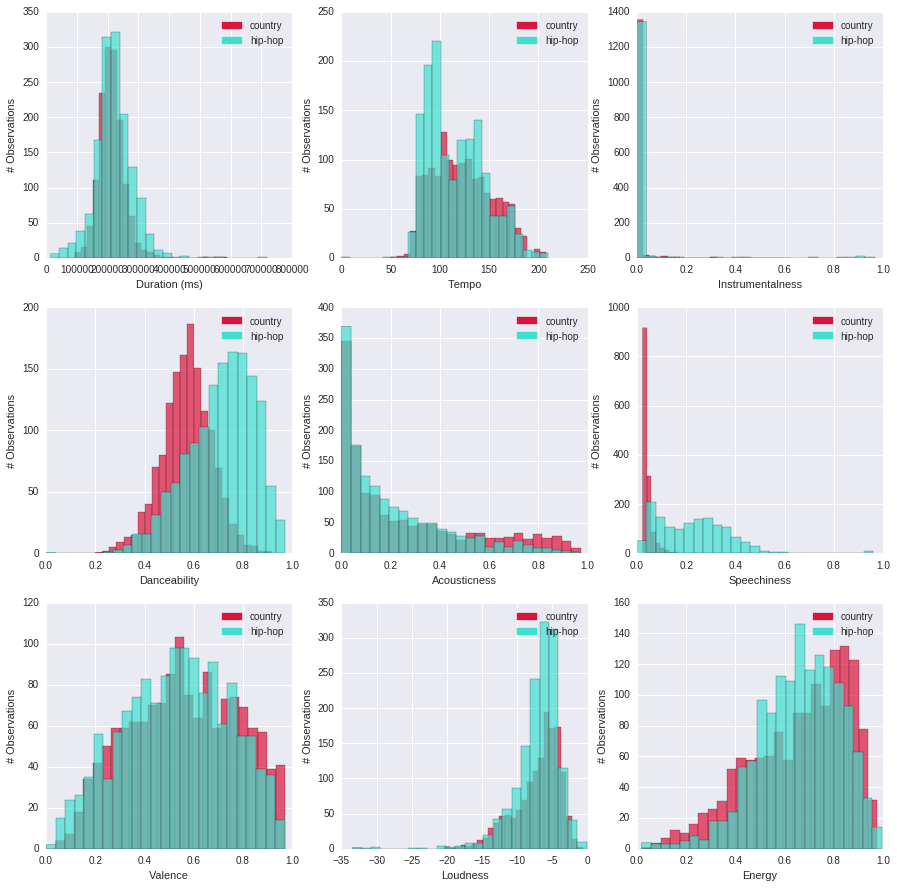

In [8]:
country_labels = df[df['class'] == 1]
hiphop_labels = df[df['class'] == 0]

histograms(country_labels, hiphop_labels, pos_name='country', neg_name='hip-hop')

### Correlation Matrix

Using a correlation matrix, we can get an indication of how different variables in the dataset are related to one another. This is important to consider for our particular use case due to the following reasons:
* Our datasets are relatively small, and thus if we have too many features relative to the number of observations, we risk undersampling and suffering from the "curse of dimensionality"
* If we have two highly correlated features, then one of them will not any additional information. In this case, it might be useful to reduce the number of features we are using

If our base classifier performance is suffering due to a high number of correlated features, there are techniques that we can use to extract relevant features and discard features that do not add any value, such as principal component analysis (PCA).

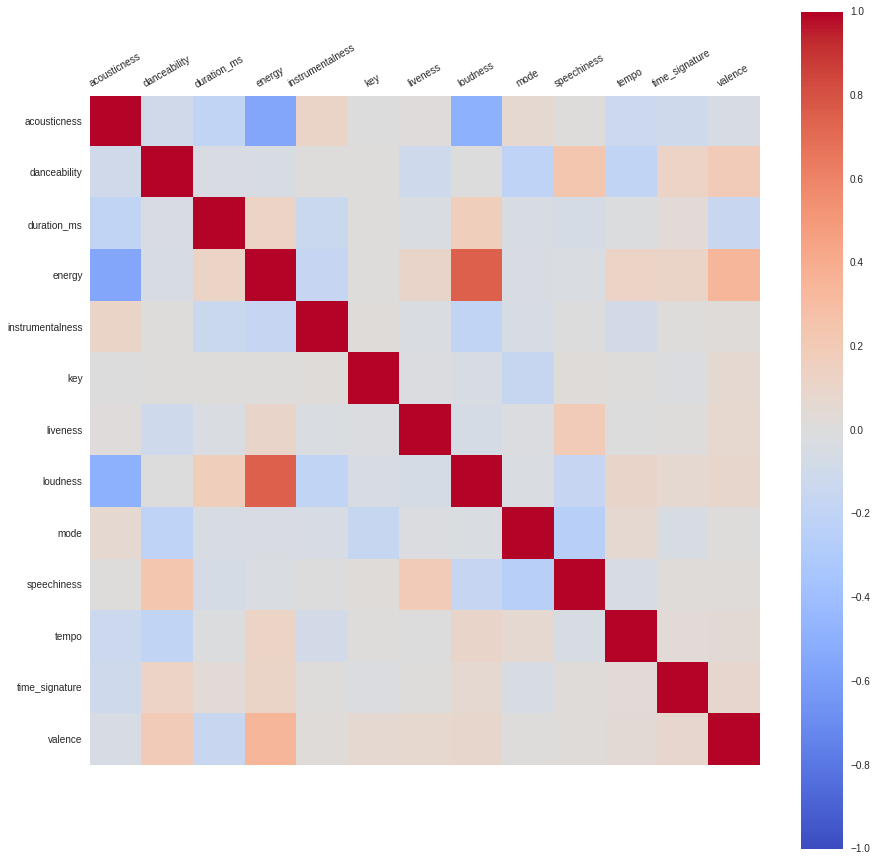

In [9]:
plt.rcParams["axes.grid"] = False
correlation_matrix(df)

Based on the correlation matrix, it looks like "loudness" and "energy" have a high positive correlation, and acousticness has a high negative correlation with both "energy" and "loudness." However, after looking at the values behind the correlation matrix, it doesn't seem like any of thes features are perfectly correlated with one another. 

The correlation coefficient between "energy" and "loudness" is around **0.74**, and the correlation coefficients between "acousticness" and "energy", "loudness" are around **-0.55** and **-0.49** respectively. Therefore, there is value in keeping all of these features in our training data because each individual feature will provide some degree of information gain.

In [10]:
correlations = df.drop(['class'], axis=1).corr()
print "Correlation coefficients for energy"
print correlations.loc['energy'].sort_values(ascending=False)
print '\n'
print "Correlation coefficients for acousticness"
print correlations.loc['acousticness'].sort_values(ascending=True)

Correlation coefficients for energy
energy              1.000000
loudness            0.744786
valence             0.337772
duration_ms         0.123358
tempo               0.119154
time_signature      0.109868
liveness            0.102365
key                 0.003536
speechiness        -0.024601
mode               -0.038928
danceability       -0.045552
instrumentalness   -0.166925
acousticness       -0.548577
Name: energy, dtype: float64


Correlation coefficients for acousticness
energy             -0.548577
loudness           -0.489477
duration_ms        -0.180373
tempo              -0.124375
time_signature     -0.105764
danceability       -0.101198
valence            -0.049905
key                -0.004449
speechiness         0.000451
liveness            0.012820
mode                0.062179
instrumentalness    0.111535
acousticness        1.000000
Name: acousticness, dtype: float64


## Step 6 - Classifier benchmarking

After some very basic data exploration and analysis, we are ready to start benchmarking different classifiers to determine which one we should use to help us predict "good" versus "bad" songs.

Firstly, we will convert the Pandas data frame object into its Numpy ndarray representation, since most scikit-learn models require an array-like data set with integer or float values.

Then, we will need to split our data into features and classes (X and y, respectively) and create our train and test datasets. We will reserve 20% of the total data for our test dataset.

In [11]:
# convert data frame to ndarray
data = df.as_matrix()

# split data into labels and features
X = data[:, 1:]
y = data[:, 0]

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

We will be benchmarking a number of base classifiers from the scikit-learn library, without too many modifications to the default parameters for each classifier. Once we have identified the strongest base classifier (based on AUC ROC), we will improve on that classifier's performance through a few techniques. The classifiers that we will look at are:
* Gaussian Naive Bayes classifier
* K-nearest neighbors classifier
* Random forest classifier
* Adapative boosting (AdaBoost) classifier
* Extreme gradient boosted classifier (XGBoost)

### Gaussian naive Bayes

The Gaussian naive Bayes classifier is based on applying Bayes' theorem with the assumption of independence between every pair of features. Without getting into too much detail, it works through maximum a posteriori (MAP) estimation to calculate the probability of a class variable _y_ given a dependent feature vector _x1_ and the relative frequency of class _y_ in the training set. 

The Gaussian implementation of naive Bayes assumes that the likelihood of the features is Gaussian, and estimates the mean and standard deviation of a given class variable _y_ through maximum likelihood estimation (MLE).

AUROC: 0.601754385965 
Accuracy: 0.601754385965 
Average precision score: 0.55852195255 
F1: 0.661698956781 
Hamming loss: 0.398245614035 

             precision    recall  f1-score   support

        0.0       0.66      0.42      0.52       285
        1.0       0.58      0.78      0.66       285

avg / total       0.62      0.60      0.59       570



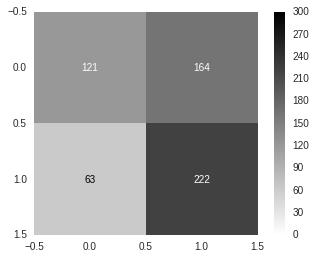

In [15]:
gnb = GaussianNB()  # instantiate model
y_pred = gnb.fit(X_train, y_train).predict(X_test)  # train model and get predictions

# get classification metrics
report = model_report(y_pred=y_pred, y_true=y_test)
print report
plot_confusion_matrix(y_test, y_pred)

### K-nearest neighbors

The K-nearest neighbors (KNN) classifier implements the KNN algorithm to perform instance-based classification - it doesn't actually build an internal model, but rather stores instances of the training data. Classification is computed from a majority vote of the nearest neighbors of each point - a query point is assigned the data class which has the most representatives within the nearest neighbors of the point. Since the default _k_ value of 5 is a little high given the small size of our dataset, we will set _k_ to 3.

AUROC: 0.538596491228 
Accuracy: 0.538596491228 
Average precision score: 0.520752223023 
F1: 0.544194107452 
Hamming loss: 0.461403508772 

             precision    recall  f1-score   support

        0.0       0.54      0.53      0.53       285
        1.0       0.54      0.55      0.54       285

avg / total       0.54      0.54      0.54       570



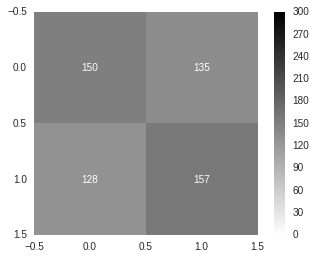

In [22]:
knn = KNeighborsClassifier(n_neighbors=3)  # instantiate model
y_pred = knn.fit(X_train, y_train).predict(X_test)  # train model and get predictions

# get classification metrics
report = model_report(y_pred=y_pred, y_true=y_test)
print report
plot_confusion_matrix(y_test, y_pred)

### Random forest

Now we will move on to the world of ensemble learners. A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. They are very popular ensemble learning techniques due to their simplicity and ease of use. One of the differences between the scikit-learn implementation and the original publication is that the scikit-learn implementation combines classifiers by averaging their probabilistic prediction, instead of letting each classifier vote for a single class.

AUROC: 0.938596491228 
Accuracy: 0.938596491228 
Average precision score: 0.915100250627 
F1: 0.938053097345 
Hamming loss: 0.0614035087719 

             precision    recall  f1-score   support

        0.0       0.93      0.95      0.94       285
        1.0       0.95      0.93      0.94       285

avg / total       0.94      0.94      0.94       570



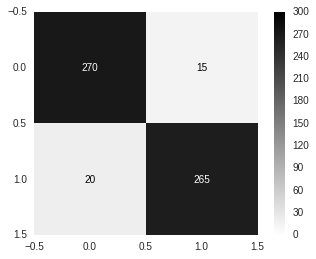

In [17]:
rf = RandomForestClassifier()  # instantiate model
y_pred = rf.fit(X_train, y_train).predict(X_test)  # train model and get predictions
y_pred = rf.predict(X_test)  # get predictions

# get classification metrics
report = model_report(y_pred=y_pred, y_true=y_test)
print report
plot_confusion_matrix(y_test, y_pred)

### AdaBoost

Adaptive boosting (AdaBoost) is a technique that is used to fit a sequence of weak learners (i.e., models that are only slightly better than random guessing, such as small decision trees) on repeatedly modified versions of the data. The predictions from all of them are then combined through a weighted majority vote (or sum) to produce the final prediction. These modifications are done through a "boosting" iteration that applies weights to each of the training samples. These iterations are performed repeatedly, and samples that were incorrectly predicted by the boosted model in the previous step have their weights increased. Thus, this forces each subsequent learner to focus on the examples that are not predicted correctly in the previous sequence. One drawback of AdaBoost is that it is prone to overfitting on noisy datasets.

AUROC: 0.935087719298 
Accuracy: 0.935087719298 
Average precision score: 0.903581367211 
F1: 0.935652173913 
Hamming loss: 0.0649122807018 

             precision    recall  f1-score   support

        0.0       0.94      0.93      0.93       285
        1.0       0.93      0.94      0.94       285

avg / total       0.94      0.94      0.94       570



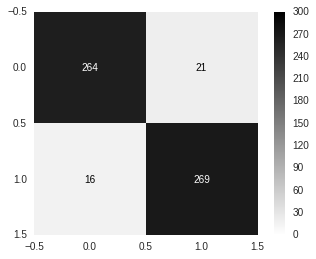

In [23]:
ada = AdaBoostClassifier()  # instantiate model
y_pred = ada.fit(X_train, y_train).predict(X_test)  # train model and get predictions
y_pred = ada.predict(X_test)  # get predictions

# get classification metrics
report = model_report(y_pred=y_pred, y_true=y_test)
print report
plot_confusion_matrix(y_test, y_pred)

### XGBoost

XGBoost is another ensemble learning library that provides a gradient boosting framework for tree algorithms. It is very popular on Kaggle and also in many production environments due to the fact that it supports various distributed processing frameworks, such as Hadoop, Spark and Flink. Like AdaBoost, a gradient boosted model comprises of an ensemble method that sequentially adds predictors and corrects previous models. However, instead of assigning different weights to the classifiers after every iteration, this method fits the new model to new residuals of the previous prediction and then minimizes the loss when adding the latest prediction (essentially, gradient descent). XGBoost implements the gradient boosting algorithm for decision tree boosting with an additional custom regularization term in the objective function.

AUROC: 0.940350877193 
Accuracy: 0.940350877193 
Average precision score: 0.915454714525 
F1: 0.94014084507 
Hamming loss: 0.059649122807 

             precision    recall  f1-score   support

        0.0       0.94      0.94      0.94       285
        1.0       0.94      0.94      0.94       285

avg / total       0.94      0.94      0.94       570



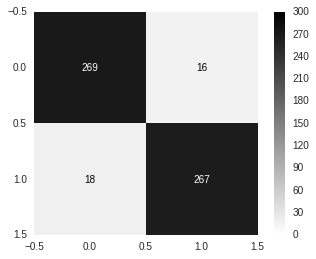

In [24]:
xgb = XGBClassifier()  # instantiate model
y_pred = xgb.fit(X_train, y_train).predict(X_test)  # train model and get predictions
y_pred = xgb.predict(X_test)  # get predictions

# get classification metrics
report = model_report(y_pred=y_pred, y_true=y_test)
print report
plot_confusion_matrix(y_test, y_pred)

# Further reading

[Spotify’s Discover Weekly: How machine learning finds your new music](https://hackernoon.com/spotifys-discover-weekly-how-machine-learning-finds-your-new-music-19a41ab76efe)

[Making Your Own Discovery Weekly](https://towardsdatascience.com/making-your-own-discover-weekly-f1ac7546fedb)

[Algorithmic Music Recommendations at Spotify](https://www.slideshare.net/MrChrisJohnson/algorithmic-music-recommendations-at-spotify/16-Section_nameMonday_January_13_1416)

[Collaborative Filtering at Spotify](https://www.slideshare.net/erikbern/collaborative-filtering-at-spotify-16182818/63)

[Python Spotipy API](https://spotipy.readthedocs.io/en/latest/)

[Spotify Web API](https://developer.spotify.com/web-api/)